In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from scipy.optimize import minimize

This notebook provides a way to visualize predicted HFX values against the actual VSSE vs. HFX curves. It also lists the average errors of predictions in both HFX% and kcal/mol.

In [2]:
csd_sse_df = pd.read_csv('../data/cleaned_csd76_sse.csv').set_index('Unnamed: 0')
csd_hfx_df = pd.read_csv('../data/CSD76targets.csv').set_index('Unnamed: 0')
csd_76 = pd.read_csv('../data/CSD-76.csv').set_index('name')

vss_sse_df = pd.read_csv('../data/cleaned_vss452_sse.csv').set_index('Unnamed: 0')
#rename so that the convention matches the original VSS-452
names = {}
for name in vss_sse_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_sse_df = vss_sse_df.rename(index=names)

vss_hfx_df = pd.read_csv('../data/VSS452targets.csv').set_index('Unnamed: 0')
names = {}
for name in vss_hfx_df.index:
    elems = name.split('/')
    names[name] =elems[-1]
vss_hfx_df = vss_hfx_df.rename(index=names)

vss_452 = pd.read_csv('../data/VSS-452.csv').set_index('name')

#feed in a dataframe of predictions
pred_df = pd.read_csv('../data/tuned_targets.csv').set_index('Unnamed: 0')
pred_df

,Tuned LS PBE,Tuned HS PBE,Tuned LS SCAN,Tuned HS SCAN
Unnamed: 0,,,,
Co_ADETCO_comp_0_3111,39.565201,45.526047,37.351151,42.374649
Co_AFULAO_comp_0_411,37.324142,40.689774,31.631851,36.523590
Co_BOTQEH_comp_0_222,38.490601,44.498138,35.250320,41.414032
Co_CAASPC_comp_3_33,35.642471,41.704178,28.450699,38.991852
Co_CEWTUT_comp_0_42,38.745193,42.184219,35.589218,38.968887
...,...,...,...,...
Mn_MEDHOS_comp_0_3111,32.462540,51.086578,31.270523,52.612915
Mn_MNACAC_comp_0_2211,100.000000,79.100723,100.000000,79.558945
Mn_PUKJIR_comp_0_111111,64.538193,65.000000,64.463959,62.511139


# Visualize Predictions and Errors

In [3]:
def pred_energy(structure, dataset, functional, target_name):
    #structure is the name of the complex, dataset is the dataframe predictions are stored in, 
    #functional is the functional used, and target_name is the column name.
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    else:
        raise ValueError("Specify a valid dataset!")
    pred_hfx = pred_df.loc[structure][target_name]
    if np.isnan(pred_hfx):
        return
    
    sses = []
    all_increments = np.arange(0, 101, 5)
    increments = []
    for increment in all_increments:
        sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
        if not np.isnan(sse):
            increments.append(increment)
            sses.append(sse)
    if len(increments) < 5:
        #print('Not enough converged values!')
        return

    line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')
    return line(pred_hfx)

def sse_vs_hfx(structure, dataset, target_names):
    #target_names is a list of the names of targets for PBE and SCAN, respectively.
    if dataset == 'csd':
        df = csd_76
        sse_df = csd_sse_df
        hfx_df = csd_hfx_df
    elif dataset == 'vss':
        df = vss_452
        sse_df = vss_sse_df
        hfx_df = vss_hfx_df
    reference = df.loc[structure]['dlpno-CCSD_T.vertsse']
    plt.figure()
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    for idx, functional in enumerate(['pbe', 'scan']):
        target_name = target_names[idx]
        all_increments = np.arange(0, 101, 5)
        increments = []
        sses = []
        for i, increment in enumerate(all_increments):
            sse = sse_df.loc[structure][functional + '_hfx_' + str(increment)]
            if not np.isnan(sse):
                sses.append(sse)
                increments.append(increment)
        ax[idx].plot(increments, sses, '-o', label='True Values', linewidth=3, color='b')
        ax[idx].set_xlabel('HFX Fraction')
        ax[idx].set_ylabel('SSE (kcal/mol)')
        ax[idx].set_title(structure + ', ' + functional)
        if len(increments) < 5:
            print('Not enough converged values!')
            continue
        
        line = interp1d(increments, sses, kind='linear', fill_value='extrapolate')

        #ax[idx].plot(np.arange(0, 101, 1), line(np.arange(0, 101, 1)), label='Line (closest 2)')
        ax[idx].axhline(reference, linestyle='--', label=f'Reference Energy={reference:1.3f}', color='C1')
        hfx = hfx_df.loc[structure]['hfx_' + functional]
        ax[idx].plot(hfx, line(hfx), 'o', label=f'Estimated HFX={hfx:1.3f}', color='C1')
        ax[idx].axvline(pred_df[target_name][structure], linestyle='--', color='C2', label=f'Predicted HFX={pred_df[target_name][structure]:1.3f}')
        if pred_energy(structure, dataset, functional, target_name) is not None:
            ax[idx].plot(pred_df[target_name][structure], pred_energy(structure, dataset, functional, target_name), 'o', color='C2', label=f'Predicted Energy={pred_energy(structure, dataset, functional, target_name):1.3f}')
        ax[idx].legend()

<Figure size 640x480 with 0 Axes>

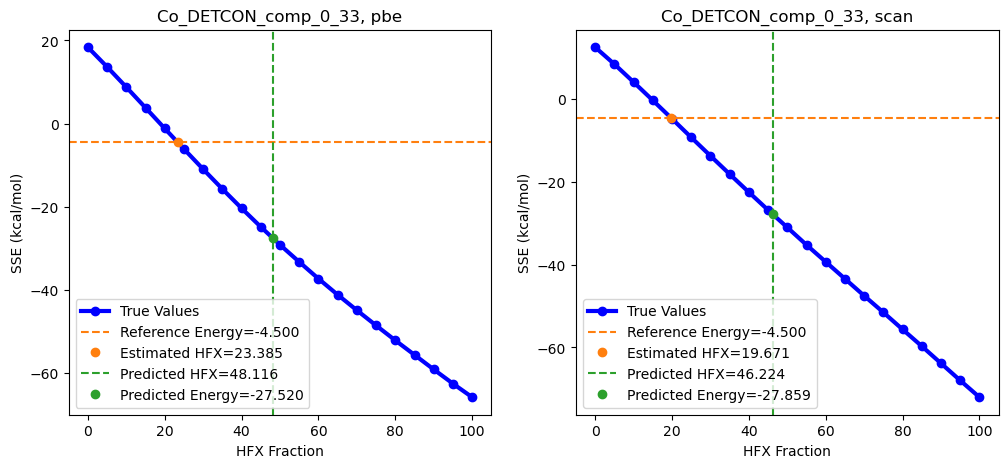

In [4]:
sse_vs_hfx('Co_DETCON_comp_0_33', 'csd', ['Tuned HS PBE', 'Tuned HS SCAN'])

# Get Mean Absolute Errors

In [5]:
#this should be vss if the prediction dataframe is on VSS-452-HFX data, csd if on CSD-76-HFX data.
dataset = 'csd'

#these should be the names of the columns you want to analyze for PBE and SCAN, respectively.
pbe_name = 'Tuned LS PBE'
scan_name = 'Tuned LS SCAN'

if dataset == 'csd':
    hfx_df = csd_hfx_df
    reference_df = csd_76
elif dataset == 'vss':
    hfx_df = vss_hfx_df
    reference_df = vss_452

pbe_errors = []
scan_errors = []

for struct in tqdm(pred_df.index.to_list()):
    reference = reference_df.loc[struct]['dlpno-CCSD_T.vertsse']
    pbe_energy = pred_energy(struct, dataset, 'pbe', pbe_name)
    if pbe_energy is not None:
        pbe_errors.append(reference - pbe_energy)
    scan_energy = pred_energy(struct, dataset, 'scan', scan_name)
    if scan_energy is not None:
        scan_errors.append(reference-scan_energy)

print(f'The number of points for PBE is {len(pbe_errors)}.')
print(f'The number of points for SCAN is {len(scan_errors)}.')

print(f'The MAE for PBE is {np.abs(np.array(pbe_errors)).mean():1.2f} kcal/mol.')
print(f'The MAE for SCAN is {np.abs(np.array(scan_errors)).mean():1.2f} kcal/mol.')

print(f'The MAE for PBE is {np.abs((hfx_df["hfx_pbe"].clip(0, 100) - pred_df[pbe_name]).dropna()).mean(): 1.2f} HFX%.')
print(f'The MAE for PBE is {np.abs((hfx_df["hfx_scan"].clip(0, 100) - pred_df[scan_name]).dropna()).mean(): 1.2f} HFX%.')

100%|██████████████████████████████████████████| 72/72 [00:00<00:00, 223.15it/s]

The number of points for PBE is 65.
The number of points for SCAN is 58.
The MAE for PBE is 7.82 kcal/mol.
The MAE for SCAN is 7.79 kcal/mol.
The MAE for PBE is  10.16 HFX%.
The MAE for PBE is  10.52 HFX%.
